In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')
sns.set_style('white')

In [4]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['X', 'P', 's', 'D', 'o']
aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']
#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [6]:
df = pd.read_pickle('CCPA.pkl.gz')
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [7]:
def _load_fcm_fl_csv(data_dpath, fname):
    df = pd.read_csv(os.path.join(data_dpath, fname), index_col=0, header=None).T
    #df = df.reset_index()
    # remove rows and columns that are all nan
    df = df.dropna(how='all')
    df = df.loc[:, df.columns.notnull()] 
    df['Sample'] = os.path.splitext(fname)[0]
    df.VALUE = pd.to_numeric(df.VALUE)
    df.day = pd.to_numeric(df.day)
    df['MODE'] = df.EXP.str.split('_', expand=True)[1]
    return df

In [8]:
data_dpath = r'fcm_and_fl'
csv_fnames = [ n for n in os.listdir(data_dpath) if n.endswith('.csv')]
temp_dfs = [_load_fcm_fl_csv(data_dpath, fname) for fname in csv_fnames]
prevfcm_df = pd.concat(temp_dfs)
prevfcm_df.loc[prevfcm_df['MODE']== 'PRO99','MODE'] = 'pro99'
prevfcm_df.loc[prevfcm_df.Sample == '9313 LD_FL1', 'PRO'] = 'MIT9313'
prevfcm_df = prevfcm_df.fillna({'ALT': 'N/A'}, )

In [9]:
fcmdflist=list()
for i in os.listdir('fcmfiles'):
    if i.endswith('.csv'):
        d = pd.read_csv(os.path.join('fcmfiles', i))
        n = os.path.splitext(i)[0]
        _, experiment, day = n.split('_')
        d['experiment'] = experiment
        d['day'] = day.replace('Days','')
        fcmdflist.append(d)
fcmdf = pd.concat(fcmdflist)
fcmdf.loc[fcmdf.PRO == 'C9B', 'PRO'] = 'MIT0604'
fcmdf['day'] = pd.to_numeric(fcmdf['day'])

In [10]:
def get_fl_day(df, row):
    x = row['day']
    e = row['EXP']
    
    possible_days = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day >= x) & (df.day < x+1), 'day' ].unique()
    if len(possible_days) == 0:
        possible_days = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day >x-1) & (df.day < x+1), 'day' ].unique()
    if len(possible_days) == 0:
        flday =  None
        flval = None
    else: 
        flday =  possible_days[0]
        flval = df.loc[(df.METHOD == 'FL') & (df.EXP == e) & (df.day == flday), 'VALUE' ].unique()[0]
    return pd.Series({'fl_day': flday, 'FL': flval})
        
    

d = prevfcm_df.apply(lambda x: get_fl_day(prevfcm_df,x), axis=1)
prevfcm_df = pd.concat([prevfcm_df, d], axis=1)
compdf = prevfcm_df.loc[prevfcm_df.METHOD == 'FCM']
compdf.rename(columns={'VALUE': 'FCM'}, inplace=True)
compdf.dropna(axis='rows', inplace=True)

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\frame.py:4218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
X = compdf['FL']
y = compdf['FCM']
res = sm.OLS(y, X).fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:                    FCM   R-squared (uncentered):                   0.849
Model:                            OLS   Adj. R-squared (uncentered):              0.849
Method:                 Least Squares   F-statistic:                              1935.
Date:                Sun, 22 Mar 2020   Prob (F-statistic):                   4.53e-143
Time:                        08:29:39   Log-Likelihood:                         -6491.9
No. Observations:                 344   AIC:                                  1.299e+04
Df Residuals:                     343   BIC:                                  1.299e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [12]:
dt = res.get_prediction(df['FL']).summary_frame(alpha = 0.05)
y_pred = dt['mean']
df['cells'] = dt['mean']
df['logcells'] = np.log(df['cells'])

In [13]:
def calculate_lag(d, use_previous_max_day=False):
    minday_fl_threshold = 0.1
    r2_threshold = 0.9

    d = d.reset_index(drop=True)
    maxindex = d.FL.idxmax()
    maxday = d.loc[maxindex]['day']
    minday = d.loc[(d.day < maxday) & (d.FL <= minday_fl_threshold), 'day'].max()
    if minday is np.NaN:
        minday = d.day.min()
    
    minday = min(maxday-7,minday)
    
    reg, intercept, coef, r2 = cp.fit_regression(d.loc[(d.day > minday) & 
                                                       (d.day <= maxday)], 'day', 'logcells')
                        
    L = maxday - ((d.loc[maxindex]['logcells'] - d.loc[0]['logcells']) / coef)
    return pd.Series({
        'maxday' : maxday,
        'minday' : minday,
        'maxlogcells' : d.loc[maxindex]['logcells'],
        'logcells0' : d.loc[0]['logcells'],
        'log10cells0' : np.log10(d.loc[0]['cells']),
        'intercept': intercept,
        'coef': coef,
        'r2': r2,
        'L' : L,
    })

def calculate_lag_wrap(d):
    minday_fl_threshold = 0.07
    minmaxday_threshold = 4
    #d  = df.loc[df.experiment_sample == 'e3, 2C'].reset_index(drop=True)
    d = d.reset_index(drop=True)
    maxindex = d.FL.idxmax()
    maxday = d.loc[maxindex]['day']

    d_no_outlier = d.loc[(d.FL > minday_fl_threshold) | 
                         (d.FL.shift() < minday_fl_threshold*2) |
                         (d.FL.shift(-1) < minday_fl_threshold*2)
                        ]
    d_withoutmaxday = d.loc[d.day < maxday]
    
    reslist = [calculate_lag(d), 
               calculate_lag(d, use_previous_max_day=True),
               calculate_lag(d_withoutmaxday),
               calculate_lag(d_no_outlier)
              ]

    maxdaysdf = d.loc[(d.FL > d.FL.shift()) & (d.FL > d.FL.shift(-1)) & 
                    (d.day < maxday)].reset_index(drop=True)
    if maxdaysdf.shape[0] > 0:
        newmaxindex = maxdaysdf.FL.idxmax()
        newmaxday = maxdaysdf.loc[newmaxindex]['day']

        if ((newmaxday is not np.NaN) and (newmaxday >= minmaxday_threshold) and 
            (d.loc[d.day == newmaxday, 'FL'].max() > (d.FL.max() / 2))):
            df_prevmax = d.loc[d.day < newmaxday]
            reslist.append(calculate_lag(df_prevmax))
        
    sorted_reslist = sorted(reslist, key=lambda x : x['r2'], reverse=True)
    return sorted_reslist[0]           

In [14]:
def computeL(maxday, maxlogcells, logcells0, coef):
    L = maxday - ((maxlogcells - logcells0) / coef)
    return L


In [53]:
def computeMaxDay(maxlogcells, logcells0, coef, L):
    maxday = ((maxlogcells - logcells0) / coef) + L
    return maxday


In [15]:
df = df.loc[~df.experiment.isin(['e7'])]

In [16]:
lagsdf = df.groupby(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample']).apply(calculate_lag_wrap)\
        .reset_index()

In [17]:
lagsdf.head()

,experiment,sample,PRO,ALT,culture,experiment_sample,maxday,minday,maxlogcells,logcells0,log10cells0,intercept,coef,r2,L
0,e1,10A,MIT0604,DE,Co_Culture,"e1, 10A",14.960417,0.715972,19.087065,14.547145,6.317745,14.770481,0.297113,0.991489,-0.319707
1,e1,10B,MIT0604,DE,Co_Culture,"e1, 10B",14.960417,0.715972,19.093980,14.384626,6.247164,14.681291,0.304705,0.982196,-0.495052
2,e1,10C,MIT0604,DE,Co_Culture,"e1, 10C",14.960417,0.000000,19.101723,14.642455,6.359137,14.734217,0.299733,0.989606,0.082945
3,e1,11A,MED4,DE1,Co_Culture,"e1, 11A",13.694444,0.000000,19.334498,15.470080,6.718571,15.012272,0.316780,0.998161,1.495394
4,e1,11B,MED4,DE1,Co_Culture,"e1, 11B",13.694444,0.000000,19.170973,15.662287,6.802045,15.101980,0.293950,0.998751,1.758092


In [18]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'logcells0', 'log10cells0',
       'intercept', 'coef', 'r2', 'L'],
      dtype='object')

In [19]:
lagsdf = lagsdf.loc[~lagsdf.experiment.isin(['e7'])]

In [20]:
fcmdf.head()

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100


In [21]:
fcmdf.loc[(fcmdf.experiment == 'exp1') & (fcmdf.day == 60), 'e'] = 'e2'
fcmdf.loc[(fcmdf.experiment == 'exp1') & (fcmdf.day == 100), 'e'] = 'e4'
fcmdf.loc[(fcmdf.experiment == 'exp1') & (fcmdf.day == 140), 'e'] = 'e5'
fdf = fcmdf.dropna(subset=['e'])
fdf.loc[:,'experiment_sample'] = fdf['e'] + ', '+ fdf['sample']
fdf['initialcells'] = fdf['PRO.1']/20
fdf['initiallogcells'] = np.log(fdf['PRO.1']/20)
fdf['initiallog10cells'] = np.log10(fdf['PRO.1']/20)

fdf.head()

C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\wosnat\Anaconda3\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\Users\wosnat\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,PRO,ALT,sample,PRO.1,ALT.1,experiment,day,e,experiment_sample,initialcells,initiallogcells,initiallog10cells
0,MED4,1A3,1A,7.485642e+06,2.992351e+07,exp1,100,e4,"e4, 1A",374282.11585,12.832765,5.573199
1,MED4,1A3,1B,6.720907e+06,2.159764e+07,exp1,100,e4,"e4, 1B",336045.34005,12.725001,5.526398
2,MED4,1A3,1C,1.121335e+07,1.742056e+07,exp1,100,e4,"e4, 1C",560667.50650,13.236883,5.748705
3,MIT9313,1A3,2A,1.415617e+06,5.134250e+06,exp1,100,e4,"e4, 2A",70780.85640,11.167344,4.849916
4,MIT9313,1A3,2B,1.018640e+06,4.885134e+06,exp1,100,e4,"e4, 2B",50931.98990,10.838246,4.706991


In [22]:
fdf.columns

Index(['PRO', 'ALT', 'sample', 'PRO.1', 'ALT.1', 'experiment', 'day', 'e',
       'experiment_sample', 'initialcells', 'initiallogcells',
       'initiallog10cells'],
      dtype='object')

In [23]:
lagsdf = pd.merge(lagsdf, fdf[['experiment_sample', 'initialcells', 'initiallogcells',
       'initiallog10cells']], on='experiment_sample', how='left')
lagsdf.loc[lagsdf.experiment == 'e1', 'initiallogcells'] = np.log(1e6)


In [50]:
lagsdf.loc[lagsdf.experiment == 'e1', 'initialcells'] = 1e6
lagsdf.loc[lagsdf.experiment == 'e1', 'initiallog10cells'] = np.log10(1e6)


In [25]:
lagsdf.loc[lagsdf['sample'] == '8C']

,experiment,sample,PRO,ALT,culture,experiment_sample,maxday,minday,maxlogcells,logcells0,log10cells0,intercept,coef,r2,L,initialcells,initiallogcells,initiallog10cells,e1 coef
87,e1,8C,MIT9312,DE,Co_Culture,"e1, 8C",13.694444,0.715972,19.019545,14.364823,6.238564,14.979449,0.293379,0.993564,-2.171439,NaN,13.815511,NaN,0.293379
165,e2,8C,MIT9312,DE,Co_Culture,"e2, 8C",12.200000,3.230000,18.724349,14.384626,6.247164,13.994116,0.410869,0.981154,1.637694,811105.9910,13.606154,5.909078,0.293379
240,e3,8C,MIT9312,DE,Co_Culture,"e3, 8C",14.000000,7.000000,17.124833,14.364823,6.238564,10.599083,0.463869,0.998893,8.050028,NaN,NaN,NaN,0.293379
316,e4,8C,MIT9312,DE,Co_Culture,"e4, 8C",15.140000,8.140000,17.998190,14.364823,6.238564,11.593399,0.425559,0.995471,6.602138,648425.6925,13.382303,5.811860,0.293379
385,e5,8C,MIT9312,DE,Co_Culture,"e5, 8C",39.840000,29.830000,18.482885,14.364823,6.238564,5.554440,0.329752,0.952388,27.351660,335.0000,5.814131,2.525045,0.293379
455,e6,8C,MIT9312,DE,Co_Culture,"e6, 8C",34.710000,20.740000,18.067113,14.364823,6.238564,8.108503,0.294393,0.944756,22.133991,NaN,NaN,NaN,0.293379


In [26]:
lagsdf.groupby('experiment')['initiallogcells'].describe().T

experiment,e1,e2,e3,e4,e5,e6
count,9.100000e+01,73.000000,0.0,72.000000,64.000000,0.0
mean,1.381551e+01,13.823901,NaN,12.694245,8.445367,NaN
std,1.786198e-15,0.633059,NaN,1.308090,2.655586,NaN
min,1.381551e+01,12.451996,NaN,5.873385,3.332205,NaN
25%,1.381551e+01,13.498208,NaN,12.528219,6.269816,NaN
50%,1.381551e+01,13.897295,NaN,13.077763,8.268281,NaN
75%,1.381551e+01,14.277954,NaN,13.420939,10.948008,NaN
max,1.381551e+01,15.174508,NaN,14.218358,12.698033,NaN


In [27]:
lagsdf['L_init'] = lagsdf.apply(lambda x: computeL(x['maxday'], x['maxlogcells'], x['initiallogcells'], x['coef']), axis=1)

In [54]:
e1coef_df = lagsdf.loc[lagsdf.experiment == 'e1', ['sample', 'coef', 'L_init'] ]
e1coef_df.index = e1coef_df['sample']

lagsdf['e1 coef'] = lagsdf['sample'].map(e1coef_df['coef'])
lagsdf['e1 L_init'] = lagsdf['sample'].map(e1coef_df['L_init'])


In [28]:
lagsdf['L_init_e1coef'] = lagsdf.apply(
    lambda x: computeL(x['maxday'], x['maxlogcells'], x['initiallogcells'], x['e1 coef']), axis=1)

In [55]:
lagsdf['maxday_e1'] = lagsdf.apply(
    lambda x: computeMaxDay(x['maxlogcells'], x['initiallogcells'], x['e1 coef'], x['e1 L_init']), axis=1)

In [29]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'logcells0', 'log10cells0',
       'intercept', 'coef', 'r2', 'L', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'e1 coef', 'L_init', 'L_init_e1coef'],
      dtype='object')

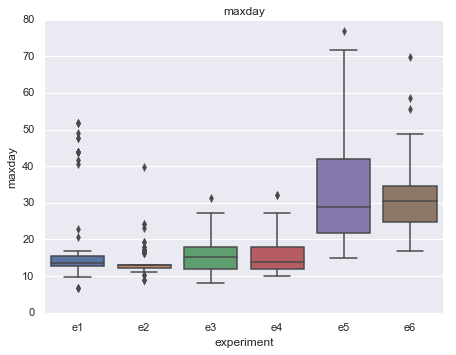

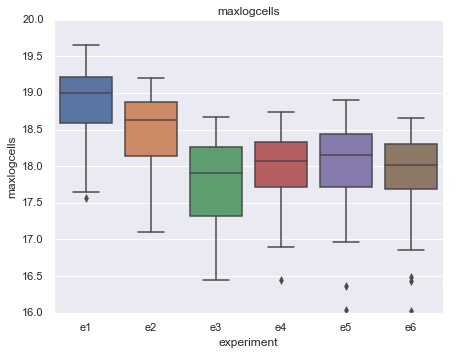

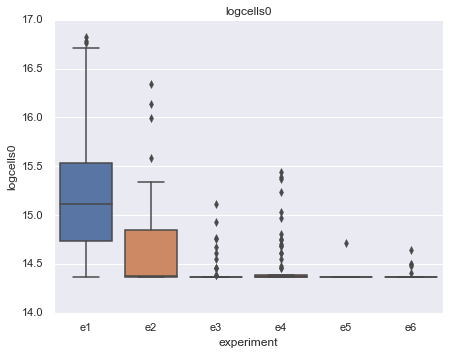

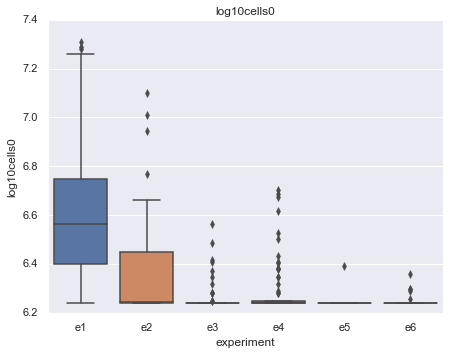

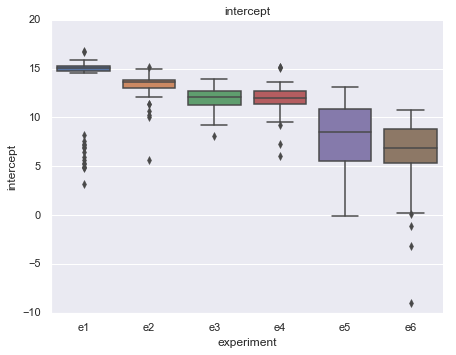

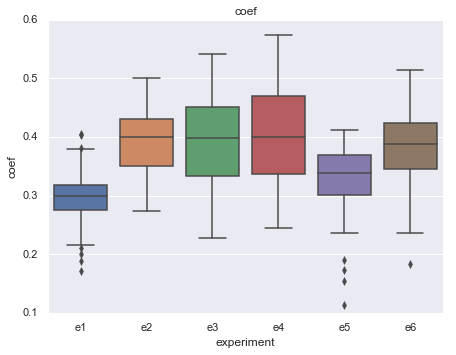

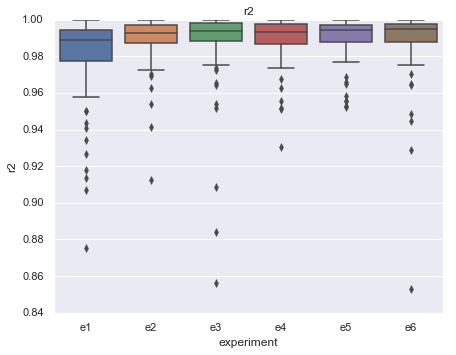

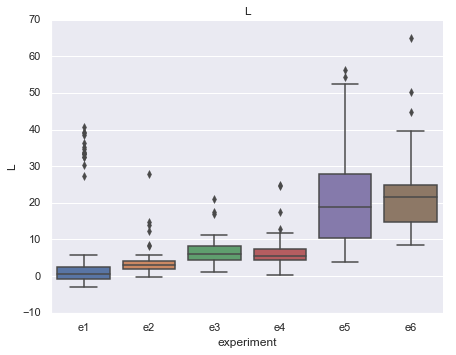

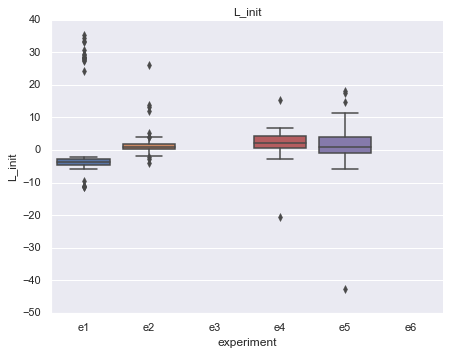

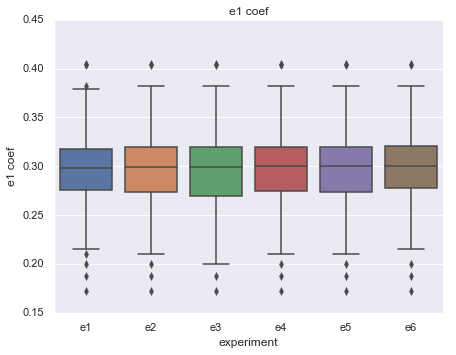

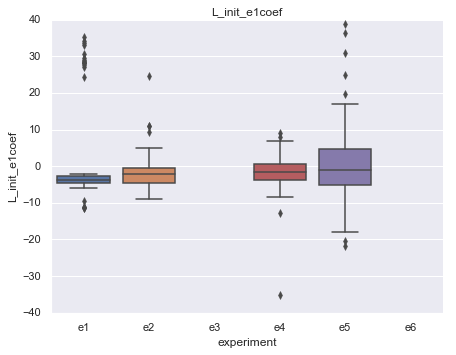

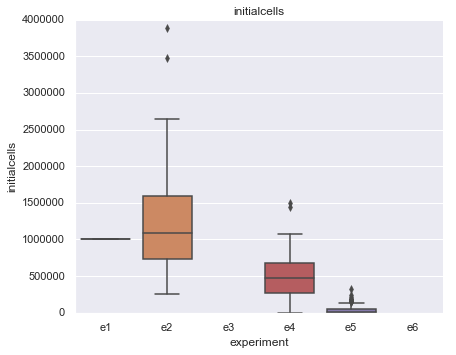

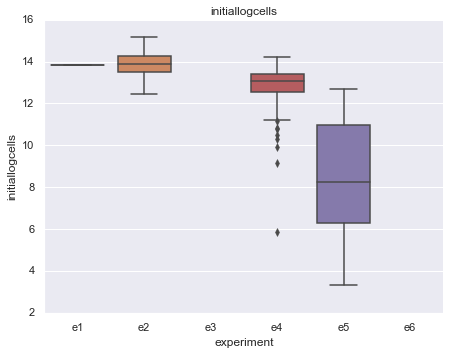

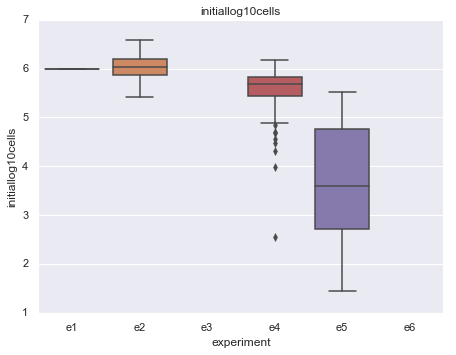

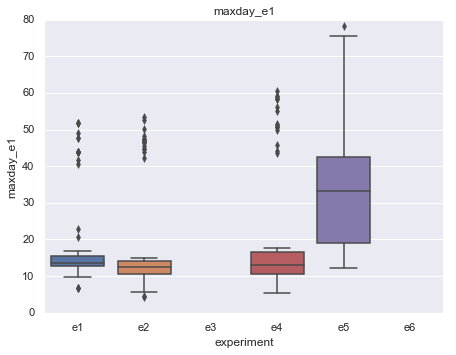

In [56]:
for i in ['maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2', 'L', 
          'L_init', 'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'maxday_e1']:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=1.3)
    plt.title(i)

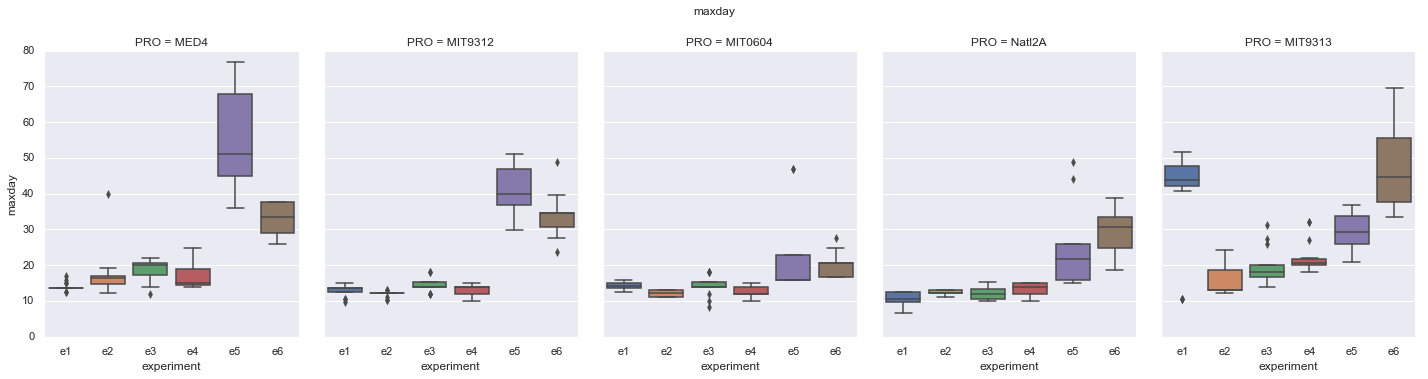

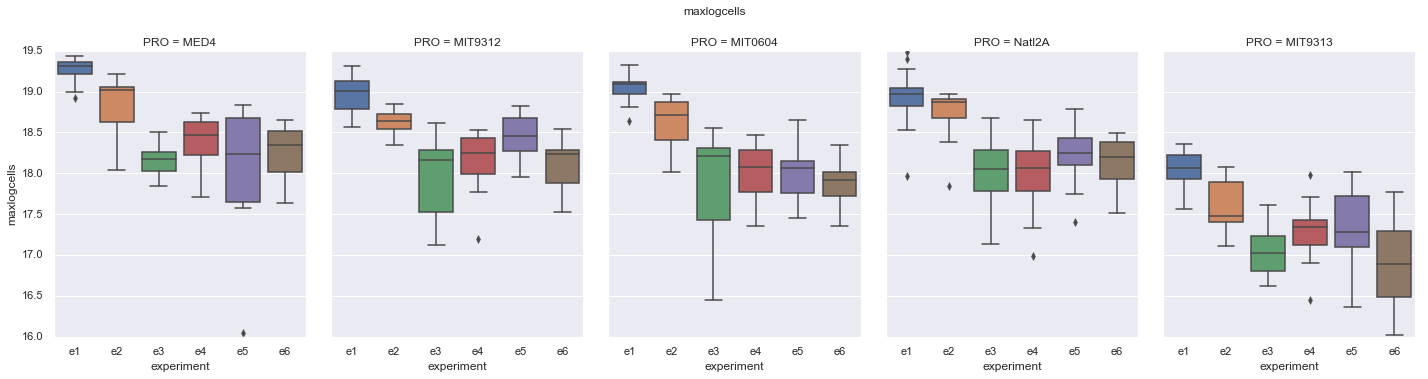

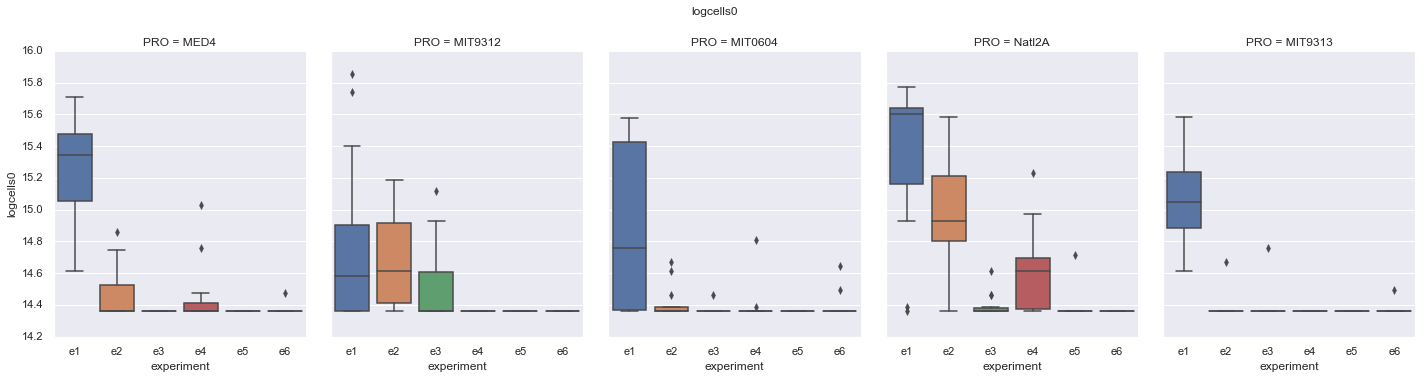

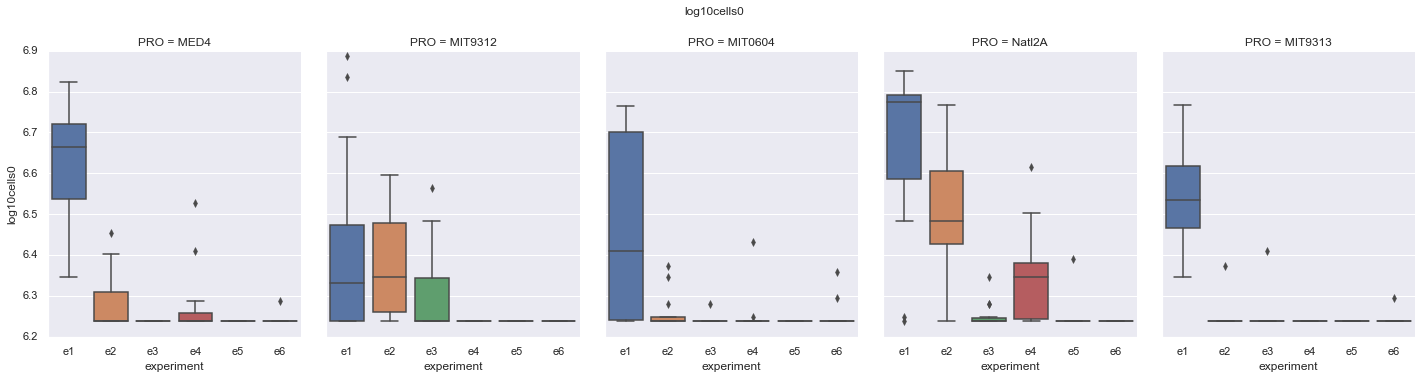

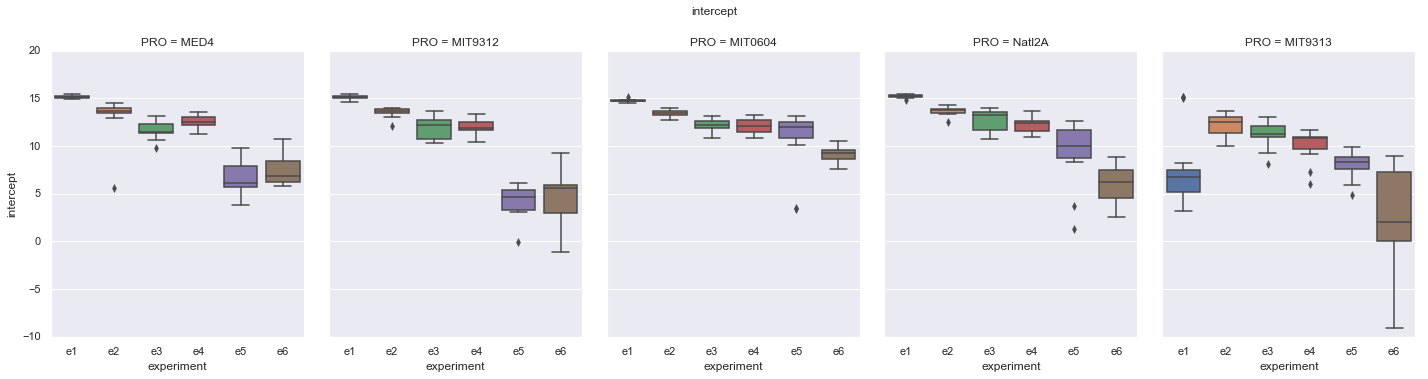

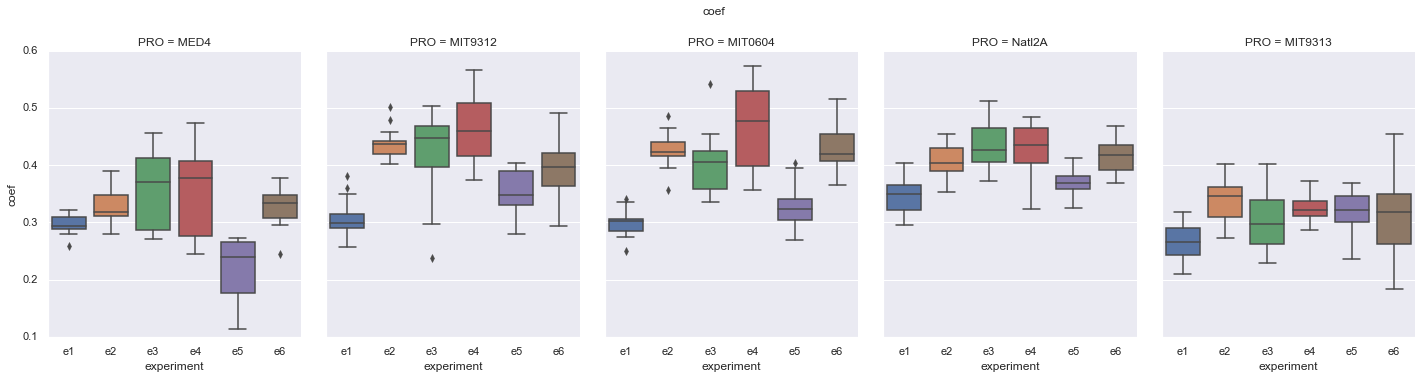

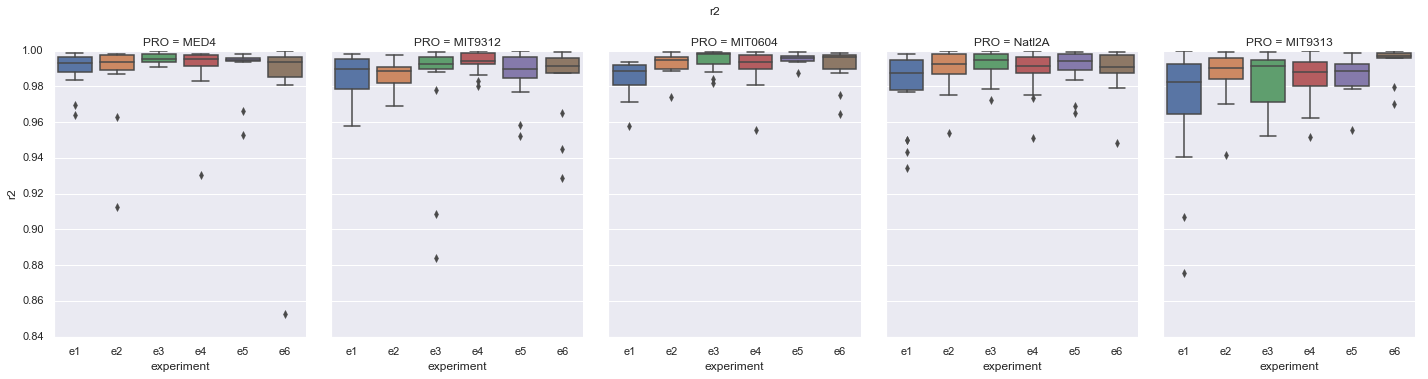

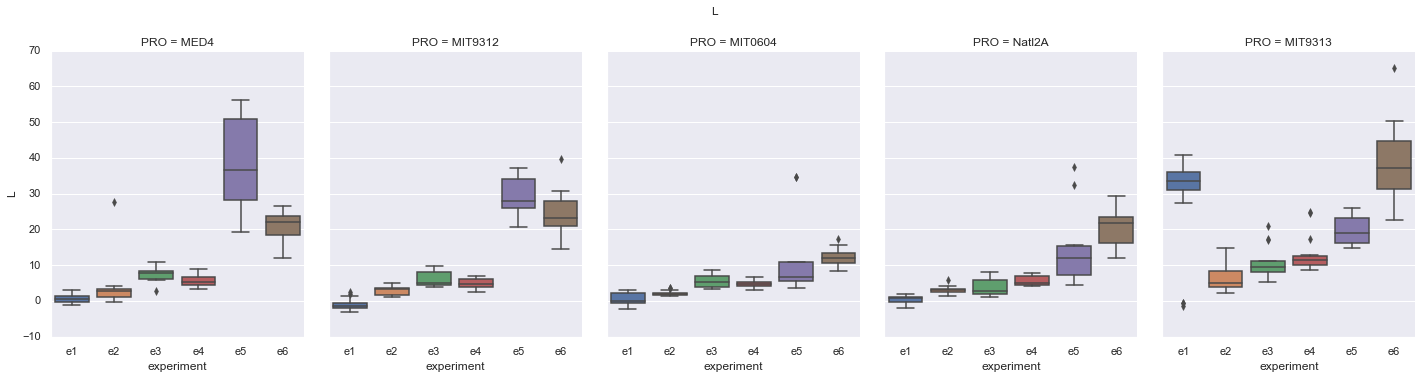

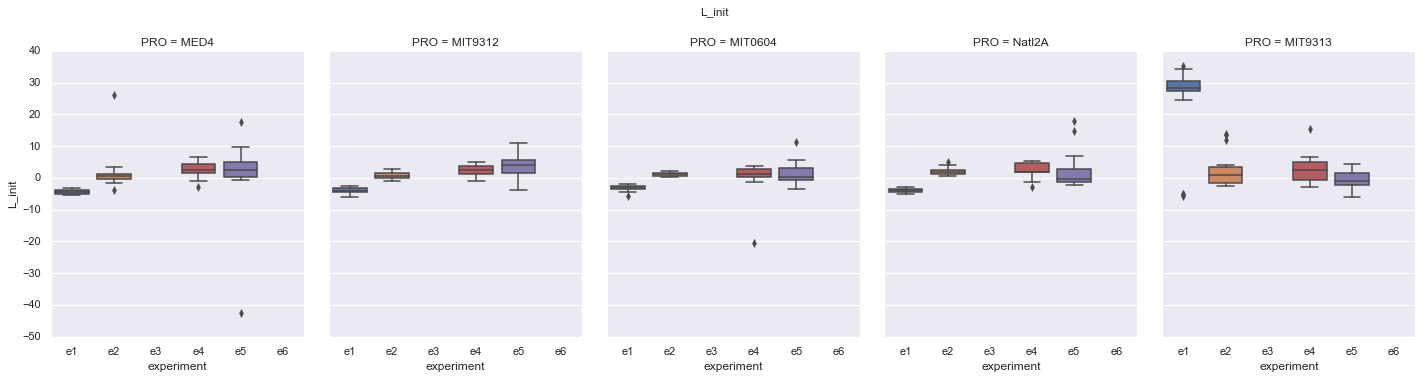

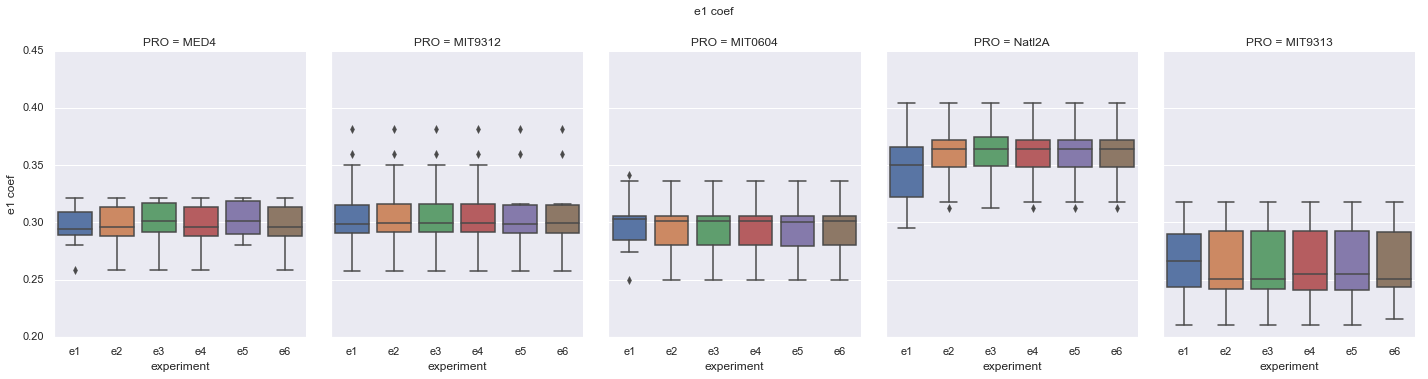

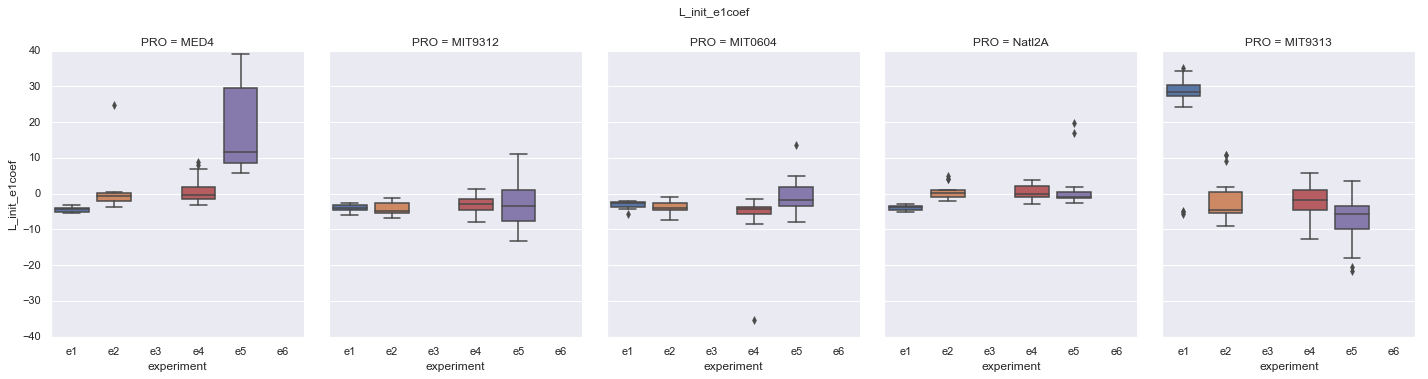

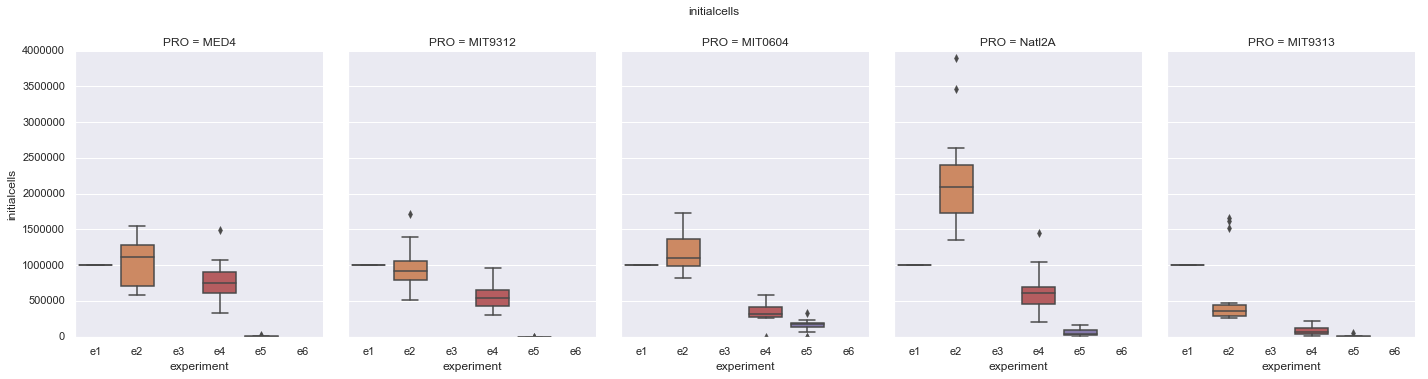

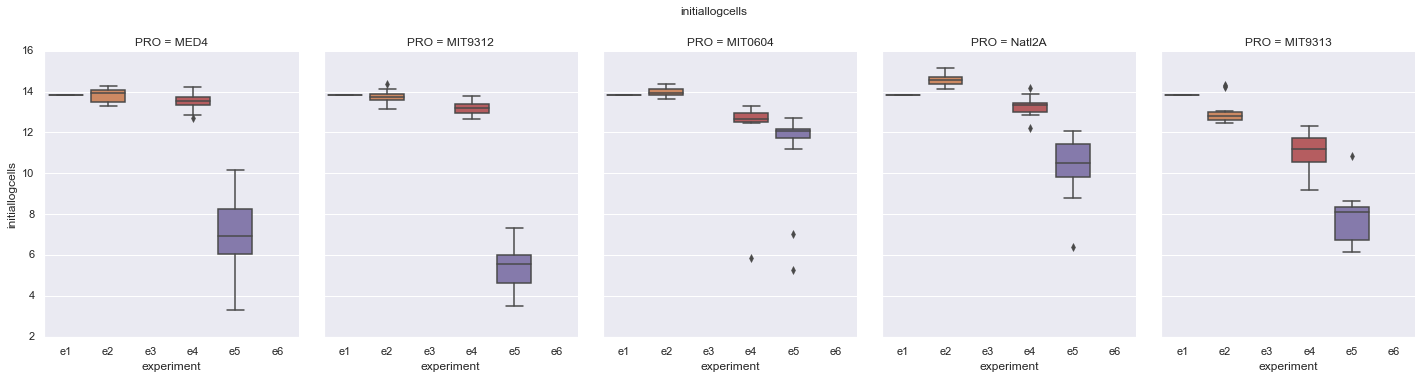

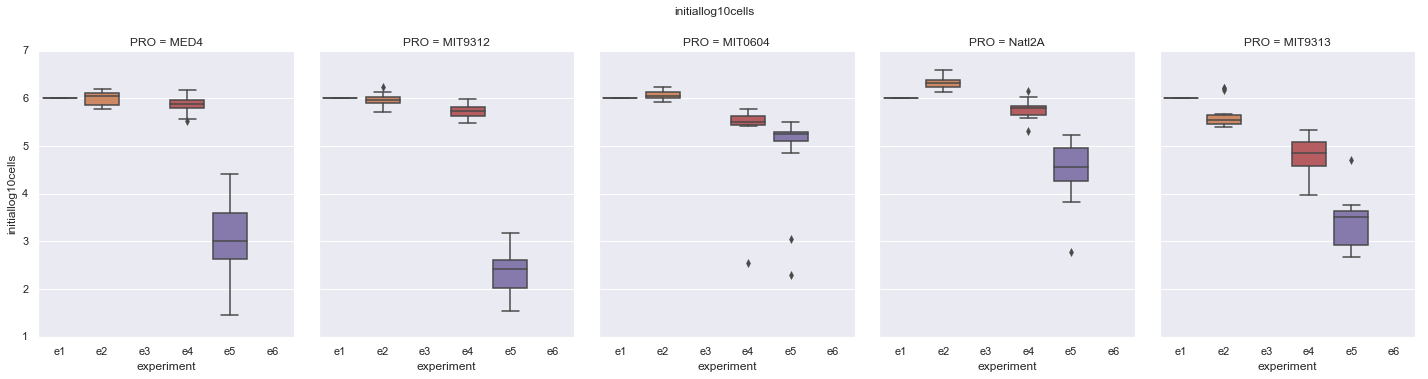

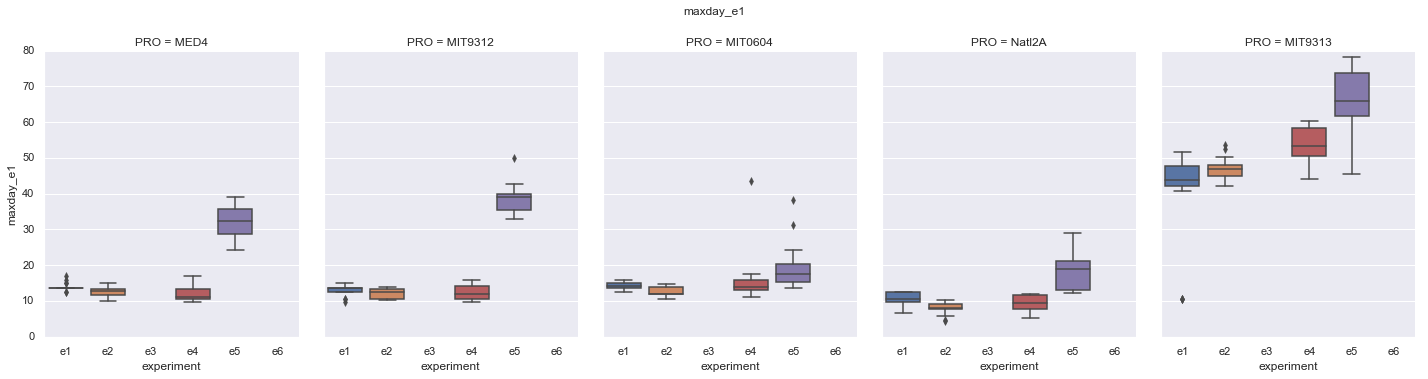

In [57]:
for i in ['maxday', 'maxlogcells', 'logcells0', 'log10cells0', 'intercept', 'coef', 'r2', 'L', 
          'L_init', 'e1 coef','L_init_e1coef', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'maxday_e1']:
    sns.catplot(data=lagsdf, x='experiment', y=i, kind='box', aspect=0.8, height=5,
                col='PRO', col_order=porder)
    plt.suptitle(i, y=1.05)

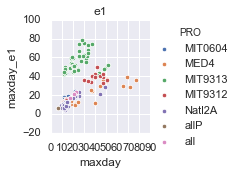

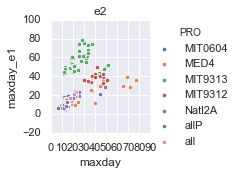

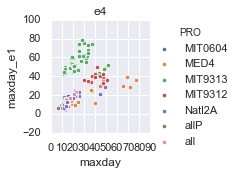

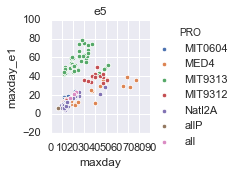

In [59]:
for e in ['e1', 'e2', 'e4', 'e5']: 
    sns.pairplot(data=lagsdf, x_vars=['maxday'], y_vars=['maxday_e1'], hue='PRO')
    plt.title(e)

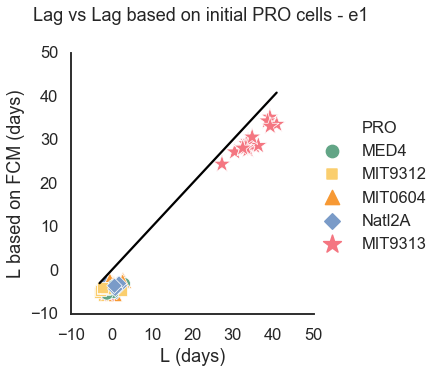

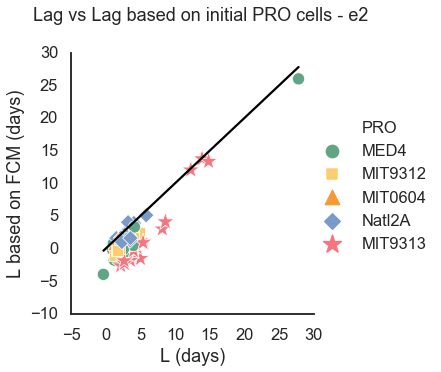

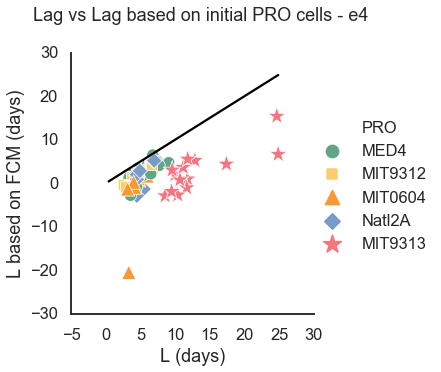

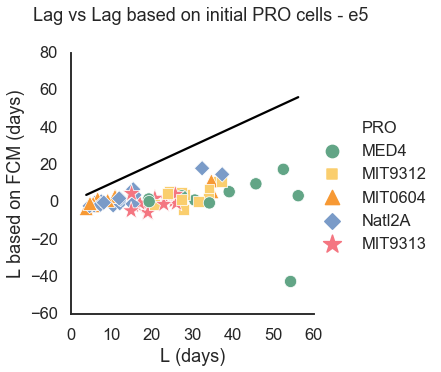

In [33]:
sns.set_context('talk')
sns.set_style('white')
for e in ['e1','e2','e4','e5']:
    g = sns.relplot(data=lagsdf.loc[lagsdf.experiment.isin([e]) & lagsdf.PRO.isin(porder)], 
            x='L', y='L_init',  hue='PRO', s=50, #legend=False,
                    hue_order=porder, palette=ppallete,
                    style='PRO', style_order=porder, markers=pmarkers,
                    size='PRO', size_order=porder, sizes=psizes,
                   )
    sns.lineplot(x=lagsdf.loc[lagsdf.experiment.isin([e]),'L'], 
                 y=lagsdf.loc[lagsdf.experiment.isin([e]),'L'], color='black', ax=g.ax, legend=False )
    g.set_axis_labels('L (days)', 'L based on FCM (days)')
    plt.suptitle(f'Lag vs Lag based on initial PRO cells - {e}', y=1.05)

In [34]:
lagsdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'logcells0', 'log10cells0',
       'intercept', 'coef', 'r2', 'L', 'initialcells', 'initiallogcells',
       'initiallog10cells', 'e1 coef', 'L_init', 'L_init_e1coef'],
      dtype='object')

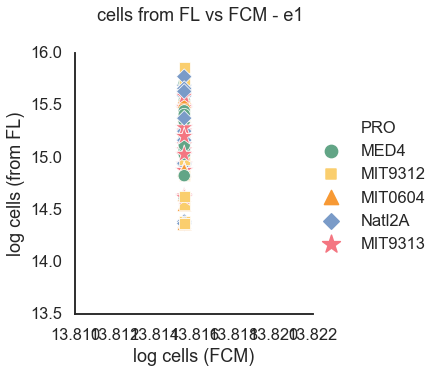

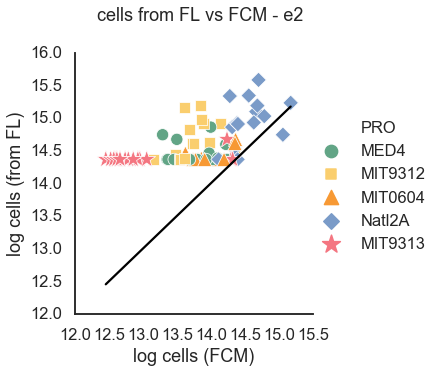

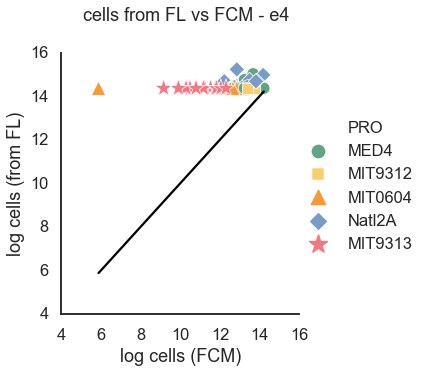

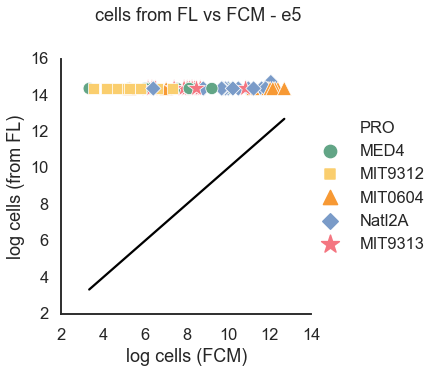

In [35]:
sns.set_context('talk')
sns.set_style('white')
for e in ['e1','e2','e4','e5']:
    g = sns.relplot(data=lagsdf.loc[lagsdf.experiment.isin([e]) & lagsdf.PRO.isin(porder)], 
            y='logcells0', x='initiallogcells',  hue='PRO', s=50, #legend=False,
                    hue_order=porder, palette=ppallete,
                    style='PRO', style_order=porder, markers=pmarkers,
                    size='PRO', size_order=porder, sizes=psizes,
                   )
    sns.lineplot(x=lagsdf.loc[lagsdf.experiment.isin([e]),'initiallogcells'], 
                 y=lagsdf.loc[lagsdf.experiment.isin([e]),'initiallogcells'], color='black', ax=g.ax, legend=False )
    g.set_axis_labels('log cells (FCM)', 'log cells (from FL)', )
    plt.suptitle(f'cells from FL vs FCM - {e}', y=1.05)
    plt.ticklabel_format(useOffset=False)

In [36]:
worse_l = lagsdf.nsmallest(10, 'L')['experiment_sample']

In [37]:
lagsdf.nsmallest(10, 'r2')

,experiment,sample,PRO,ALT,culture,experiment_sample,maxday,minday,maxlogcells,logcells0,...,intercept,coef,r2,L,initialcells,initiallogcells,initiallog10cells,e1 coef,L_init,L_init_e1coef
392,e6,11A,MED4,DE1,Co_Culture,"e6, 11A",37.590000,27.710000,17.778608,14.364823,...,8.825284,0.245229,0.852807,23.669205,NaN,NaN,NaN,0.316780,NaN,NaN
219,e3,36B,allP,all_Pro,All_Pro,"e3, 36B",14.000000,6.170000,16.655336,14.364823,...,12.783833,0.288142,0.856388,6.050747,NaN,NaN,NaN,0.260901,NaN,NaN
41,e1,22C,MIT9313,ATCC,Co_Culture,"e1, 22C",47.781250,33.886111,17.932665,14.871641,...,8.195996,0.210352,0.875528,33.229358,NaN,13.815511,NaN,0.210352,28.208587,28.208587
239,e3,8B,MIT9312,DE,Co_Culture,"e3, 8B",18.040000,10.130000,17.206238,14.364823,...,13.105084,0.236997,0.883943,6.050774,NaN,NaN,NaN,0.299371,NaN,NaN
6,e1,12A,MIT9313,DE1,Co_Culture,"e1, 12A",43.836806,33.886111,17.989164,14.627188,...,6.977780,0.250818,0.906756,30.432765,NaN,13.815511,NaN,0.250818,27.196647,27.196647
192,e3,18A,MIT9312,BS11,Co_Culture,"e3, 18A",18.040000,4.110000,18.382287,14.364823,...,13.644865,0.297595,0.908640,4.540220,NaN,NaN,NaN,0.315228,NaN,NaN
94,e2,11A,MED4,DE1,Co_Culture,"e2, 11A",16.310000,4.110000,19.008445,14.364823,...,14.120204,0.278935,0.912431,-0.337673,631071.4285,13.355174,5.800079,0.316780,-3.957328,-1.536035
68,e1,37B,all,all,All_strains,"e1, 37B",20.660417,0.000000,19.483775,16.695024,...,15.834496,0.187477,0.913771,5.785277,NaN,13.815511,NaN,0.187477,-9.573985,-9.573985
67,e1,37A,all,all,All_strains,"e1, 37A",22.951389,0.000000,19.660036,16.714292,...,15.820678,0.171782,0.918008,5.803273,NaN,13.815511,NaN,0.171782,-11.071461,-11.071461
69,e1,37C,all,all,All_strains,"e1, 37C",16.952083,0.000000,19.427418,16.826120,...,15.830044,0.199768,0.926546,3.930518,NaN,13.815511,NaN,0.199768,-11.139976,-11.139976


In [38]:
def plot_growth(es):
    sns.set(rc={'figure.figsize':(10,5)})
    maxday = lagsdf.loc[lagsdf.experiment_sample == es, 'maxday'].unique()[0]
    minday = lagsdf.loc[lagsdf.experiment_sample == es, 'minday'].unique()[0]
    r2 = lagsdf.loc[lagsdf.experiment_sample == es, 'r2'].unique()[0]
    L = lagsdf.loc[lagsdf.experiment_sample == es, 'L'].unique()[0]
    
    d = df.loc[df.experiment_sample == es].reset_index()
    d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
    d.loc[d.day > maxday, 'fitted_growth'] = np.NaN
    d.loc[d.day < minday, 'fitted_growth'] = np.NaN
    sns.lineplot(data=d,
                 x='day', y='logcells',  style=True, markers=True,label='logcells')
    sns.lineplot(data=d,
        x='day', y='fitted_growth',  style=True, markers=True,label='fit')
    plt.title(f'{es}: L={L:.2f}, r2={r2:.2f}')
    plt.show()


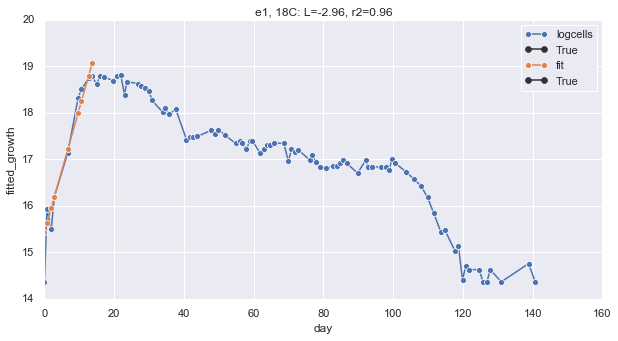

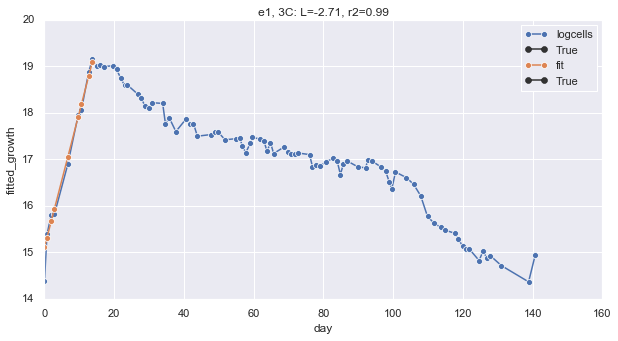

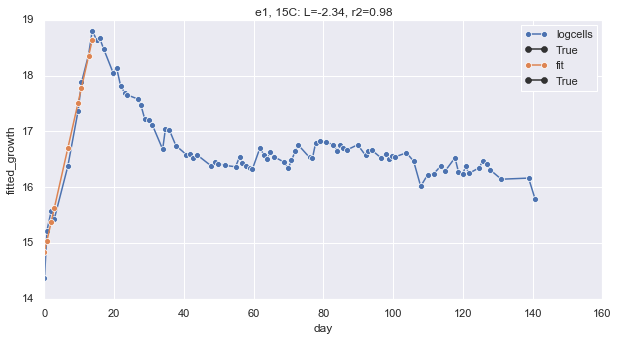

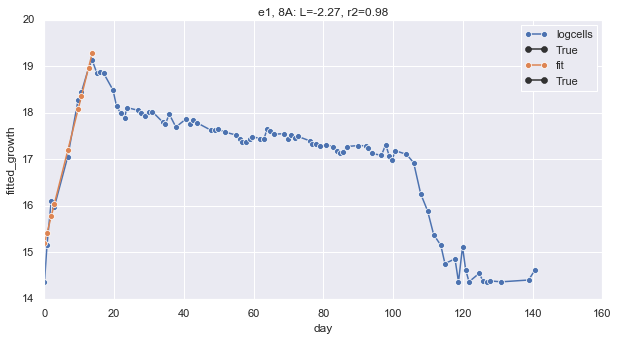

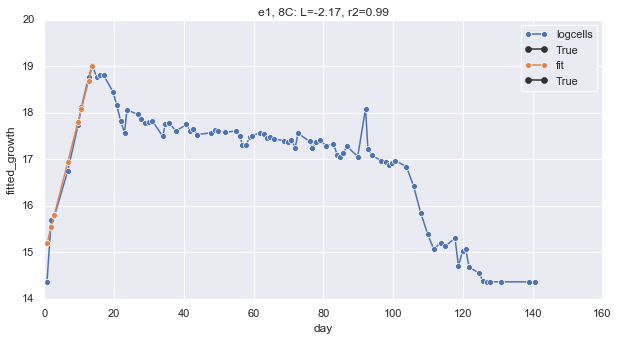

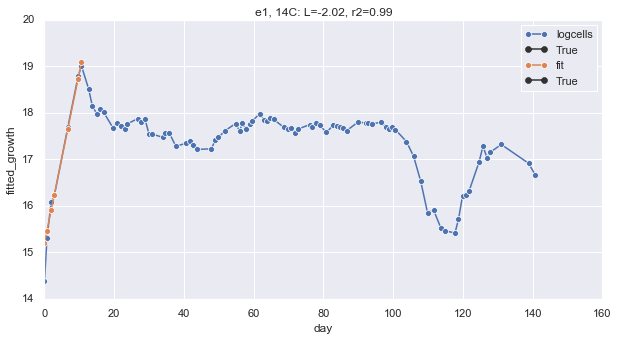

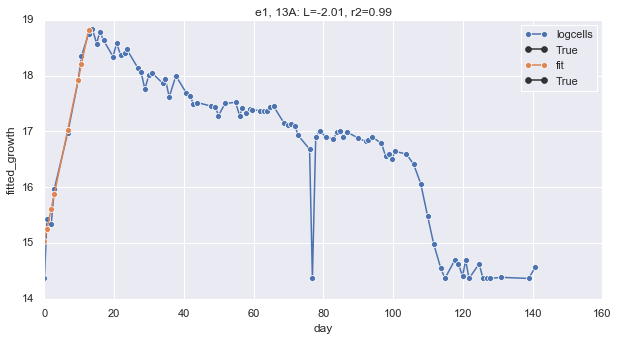

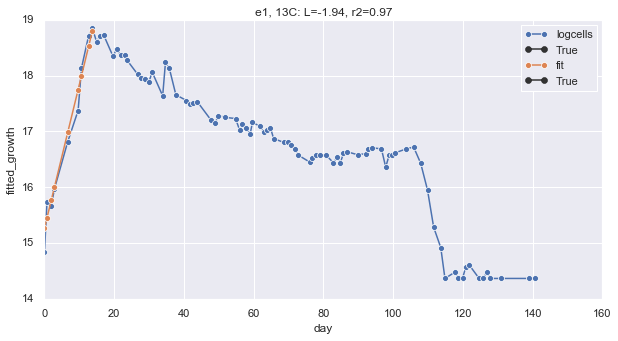

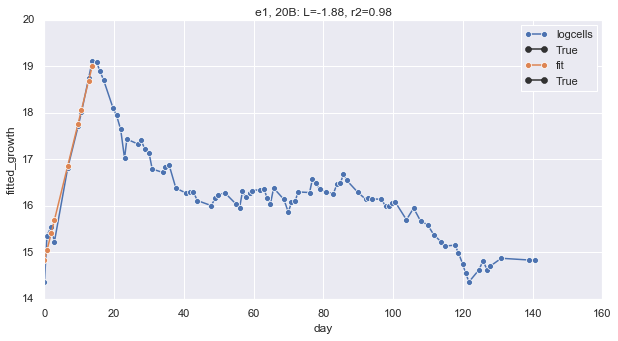

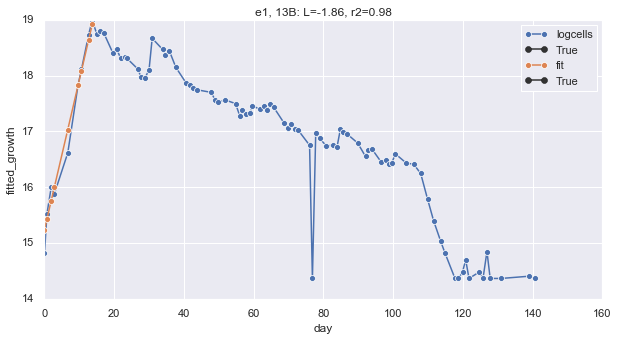

In [39]:
for es in worse_l:
    plot_growth(es)

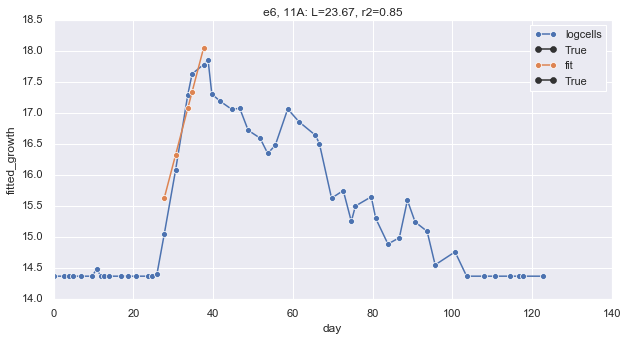

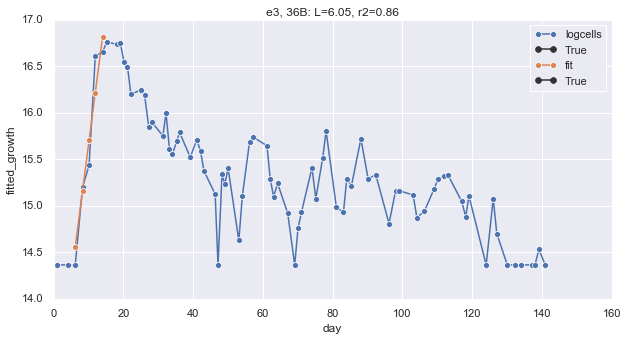

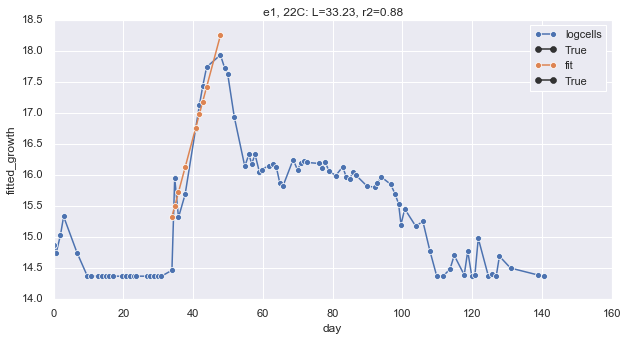

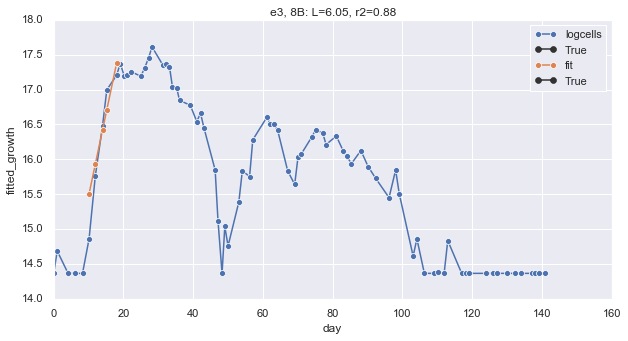

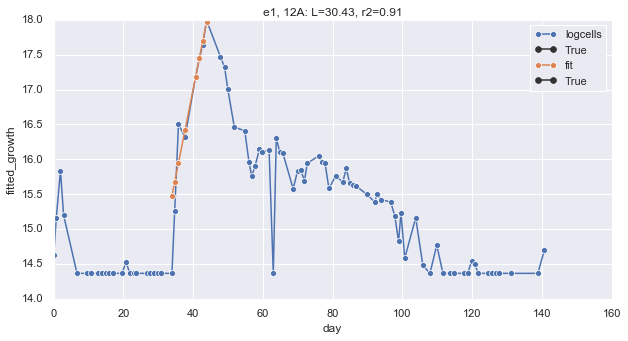

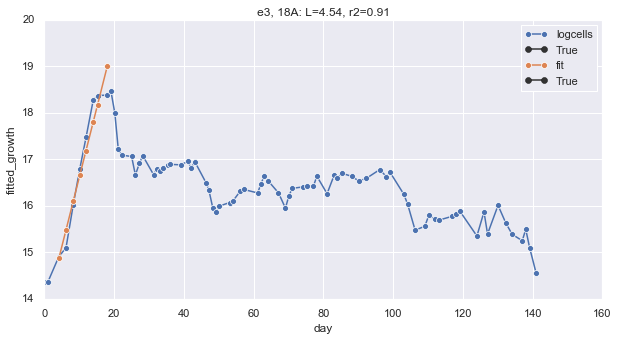

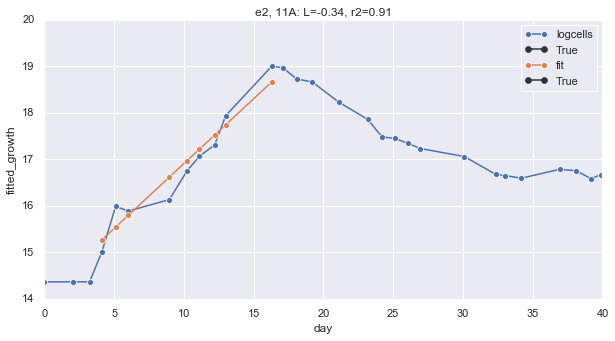

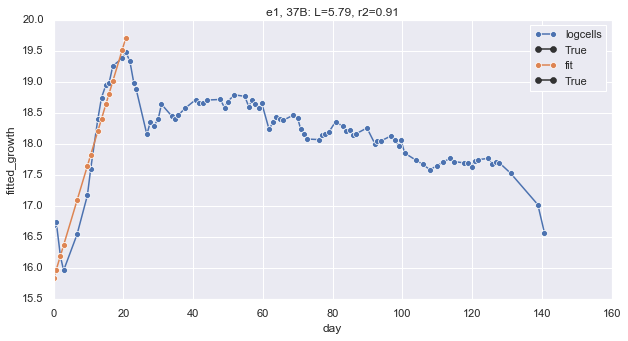

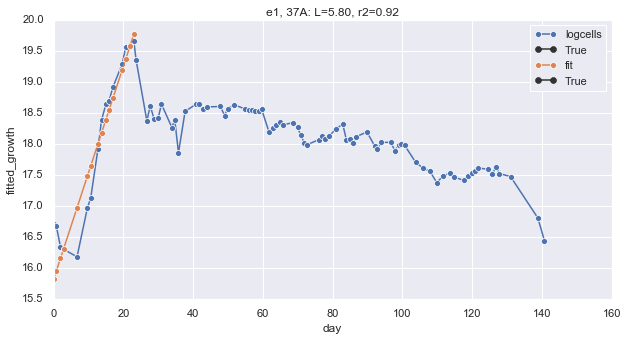

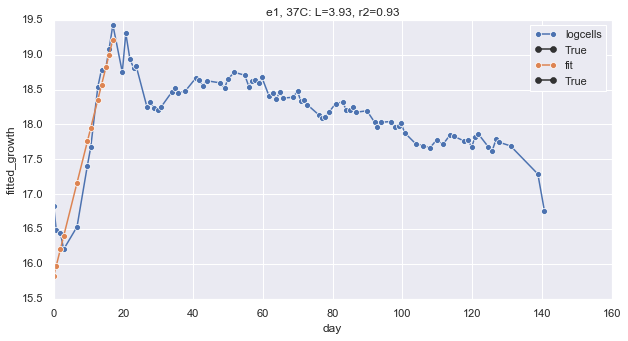

In [40]:
worse_r2 = lagsdf.nsmallest(10, 'r2')['experiment_sample']
for es in worse_r2:
    plot_growth(es)

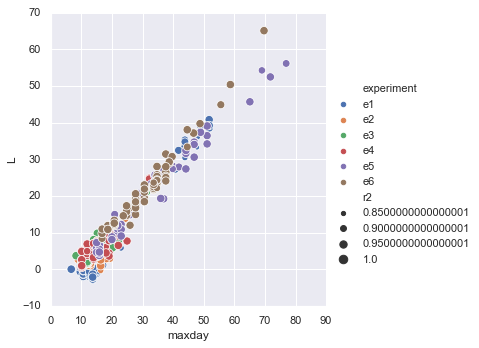

In [41]:
sns.relplot(data=lagsdf, x='maxday', y='L', hue='experiment', size='r2')

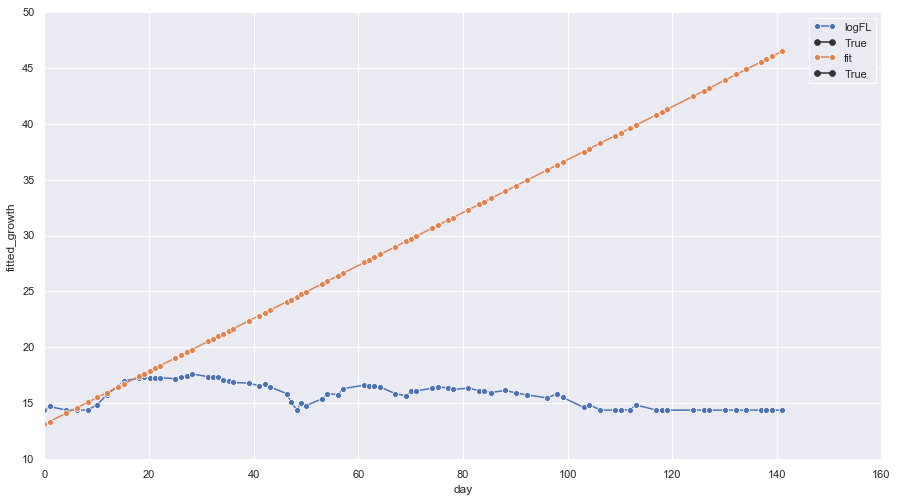

In [42]:
sns.set(rc={'figure.figsize':(15,8)})
es = 'e3, 8B'
d = df.loc[df.experiment_sample == es].reset_index()
d['fitted_growth'] = d.day*lagsdf.loc[lagsdf.experiment_sample == es, 'coef'].unique() + lagsdf.loc[lagsdf.experiment_sample == es, 'intercept'].unique()
sns.lineplot(data=d,
             x='day', y='logcells',  style=True, markers=True,label='logFL')
sns.lineplot(data=d,
    x='day', y='fitted_growth',  style=True, markers=True,label='fit')

#sns.lineplot(data=d, x='day', y='first_deriviative',  style=True, markers=True,label='1')
#sns.lineplot(data=d, x='day', y='second_deriviative',  style=True, markers=True,label='2')